In [1]:
import pandas as pd
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tinyshift.stats import BootstrapBCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.exceptions import NotFittedError
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from tinycp.regressor import ConformalizedRegressor
from tinycp.plot import plot_prediction_intervals


# EDA

In [2]:
df = pd.read_csv("/home/heylucasleao/ols-regression-challenge/data/INFLUD24-03-02-2025.csv", sep=";", encoding="latin1", low_memory=False)

In [3]:
sinais_sintomas = [
    "FEBRE", "TOSSE", "GARGANTA", "DISPNEIA", "DESC_RESP", 
    "SATURACAO", "DIARREIA", "VOMITO", "DOR_ABD", "FADIGA", 
    "PERD_OLFT", "PERD_PALA", "OUTRO_SIN", 
    #"OUTRO_DES"
]
fatores_risco = [
    "FATOR_RISC", 
    #"PUERPERA", 
    "CARDIOPATI", 
    #"HEMATOLOGI", 
    #"SIND_DOWN", 
    #"HEPATICA", 
    "ASMA", 
    "DIABETES", 
    "NEUROLOGIC", 
    "PNEUMOPATI", 
    "IMUNODEPRE", 
    #"RENAL", 
    #"OBESIDADE", 
    #"OBES_IMC", 
    "OUT_MORBI", 
    #"MORB_DESC"
]
vacinacao = [
    "VACINA_COV", 
    #"DOSE_1_COV", 
    #"DOSE_2_COV", 
    #"DOSE_REF", 
    #"DOSE_2REF", 
    #"FAB_COV1", 
    #"FAB_COV2", 
    #"FAB_COVRF", 
    #"FAB_COVRF2", 
    #"LOTE_1_COV", 
    #"LOTE_2_COV", 
    #"LOTE_REF", 
    # "LOTE_REF2", 
    #"FNT_IN_COV"
]
tratamento = [
    "ANTIVIRAL", 
    #"TP_ANTIVIR", "OUT_ANTIV", "DT_ANTIVIR", 
    #"TRAV_COV", 
    #"TIPO_TRAV", 
    #"OUT_TRAV", 
    #"DT_TRAV_COV"
]

internacao = [
    "HOSPITAL", 
    #"DT_INTERNA", 
    #"SG_UF_INTE", 
    #"CO_MU_INTE", 
    #"CO_UN_INTE", 
    "UTI", 
    #"DT_ENTUTI", 
    #"DT_SAIDUTI", 
    "SUPORT_VEN"
]
exames = [
    "RAIOX_RES", 
    #"RAIOX_OUT", 
    #"DT_RAIOX", 
    "TOMO_RES", 
   # "TOMO_OUT", 
    #"DT_TOMO", 
    "AMOSTRA", 
    #"DT_COLETA", 
    "TP_AMOSTRA", 
    #"OUT_AMOST"
]
testes_laboratoriais = [
    "RES_AN", 
    #"POS_AN_FLU", 
    #"TP_FLU_AN", 
    #"POS_AN_OUT", 
    #"AN_SARS2", 
    #"AN_VSR", 
    #"AN_PARA1", 
    #"AN_PARA2", 
    #"AN_PARA3", 
    #"AN_ADENO", 
    #"AN_OUTRO", 
    #"DS_AN_OUT"
]
rt_pcr = [
    "PCR_RESUL", 
    #"DT_PCR", 
    "POS_PCRFLU", 
    #"TP_FLU_PCR", 
    #"PCR_FLUASU", 
    #"FLUASU_OUT", 
    #"PCR_FLUBLI", 
    #"FLUBLI_OUT", 
    "POS_PCROUT",
    #"PCR_SARS2", 
    #"PCR_VSR", 
    #"PCR_PARA1", 
    #"PCR_PARA2", 
    #"PCR_PARA3", 
    #"PCR_PARA4", 
    #"PCR_ADENO", 
    #"PCR_METAP", 
    #"PCR_BOCA", 
    #"PCR_RINO", 
    #"PCR_OUTRO", 
    #"DS_PCR_OUT"
]


In [4]:
columns = (sinais_sintomas 
            + fatores_risco 
            + vacinacao 
            + tratamento 
            + internacao
            + exames
            + testes_laboratoriais
            + rt_pcr)
target = ["CASO_SRAG"]

In [5]:
df = df[columns + ["CASO_SRAG"]]

In [6]:
is_null = df.isnull().sum()

In [7]:
remove_features = is_null[is_null / len(df) > 0.70].index.tolist()

In [8]:
df = df[df.columns.drop(remove_features)]

In [9]:
df["RAIOX_RES"].value_counts()

RAIOX_RES
6.0    47708
2.0    44804
5.0    28969
1.0    23129
9.0    19501
3.0    13076
4.0     6285
Name: count, dtype: int64

In [10]:
(df.isnull().sum() / len(df)).sort_values(ascending=False)

IMUNODEPRE    0.695856
NEUROLOGIC    0.691754
PNEUMOPATI    0.691476
ASMA          0.687209
POS_PCRFLU    0.685441
DIABETES      0.676996
POS_PCROUT    0.670232
OUT_MORBI     0.666411
CARDIOPATI    0.658409
TOMO_RES      0.413032
RAIOX_RES     0.311369
OUTRO_SIN     0.273663
PERD_PALA     0.259017
PERD_OLFT     0.257681
DOR_ABD       0.249405
GARGANTA      0.242386
DIARREIA      0.240408
VOMITO        0.233641
FADIGA        0.233330
ANTIVIRAL     0.191679
SATURACAO     0.150790
DESC_RESP     0.119487
DISPNEIA      0.110783
SUPORT_VEN    0.109432
CASO_SRAG     0.109151
FEBRE         0.105394
RES_AN        0.102488
UTI           0.100743
PCR_RESUL     0.078279
TP_AMOSTRA    0.075052
TOSSE         0.065053
HOSPITAL      0.022456
AMOSTRA       0.020666
VACINA_COV    0.000191
FATOR_RISC    0.000000
dtype: float64

In [11]:
df = df.fillna(9)

In [20]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import math

def plot_histograms_grid(
    df, 
    max_plots_per_row=5, 
    height=300, 
    width=600, 
    title="Histograms Grid"
):
    """
    Creates a grid of histograms for all columns in a DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the data to plot
    max_plots_per_row : int, optional
        Maximum number of plots per row (default: 5)
    plot_height : int, optional
        Height in pixels for each individual plot row (default: 300)
    plot_width : int, optional
        Optional fixed width for the entire figure
    title : str, optional
        Title for the overall figure (default: "Histograms Grid")
    
    Returns:
    --------
    plotly.graph_objs._figure.Figure
        Plotly Figure object containing the histograms
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")
    
    num_columns = len(df.columns)
    if num_columns == 0:
        raise ValueError("DataFrame has no columns to plot")
    
    n_rows = math.ceil(num_columns / max_plots_per_row)
    n_cols = min(num_columns, max_plots_per_row)
    
    fig = make_subplots(
        rows=n_rows,
        cols=n_cols,
        subplot_titles=df.columns,
        horizontal_spacing=0.1,
        vertical_spacing=0.2/n_rows
    )
    
    for i, column in enumerate(df.columns):
        row = (i // n_cols) + 1
        col = (i % n_cols) + 1
        
        fig.add_trace(
            go.Histogram(x=df[column], name=column),
            row=row, col=col
        )
    
    total_height = n_rows * height
    
    fig.update_layout(
        title_text=title,
        showlegend=False,
        height=total_height,
        width=width,
        margin=dict(t=100 if title else 50)
    )
    
    fig.update_annotations(
        font_size=10,
        yshift=10
    )
    
    return fig



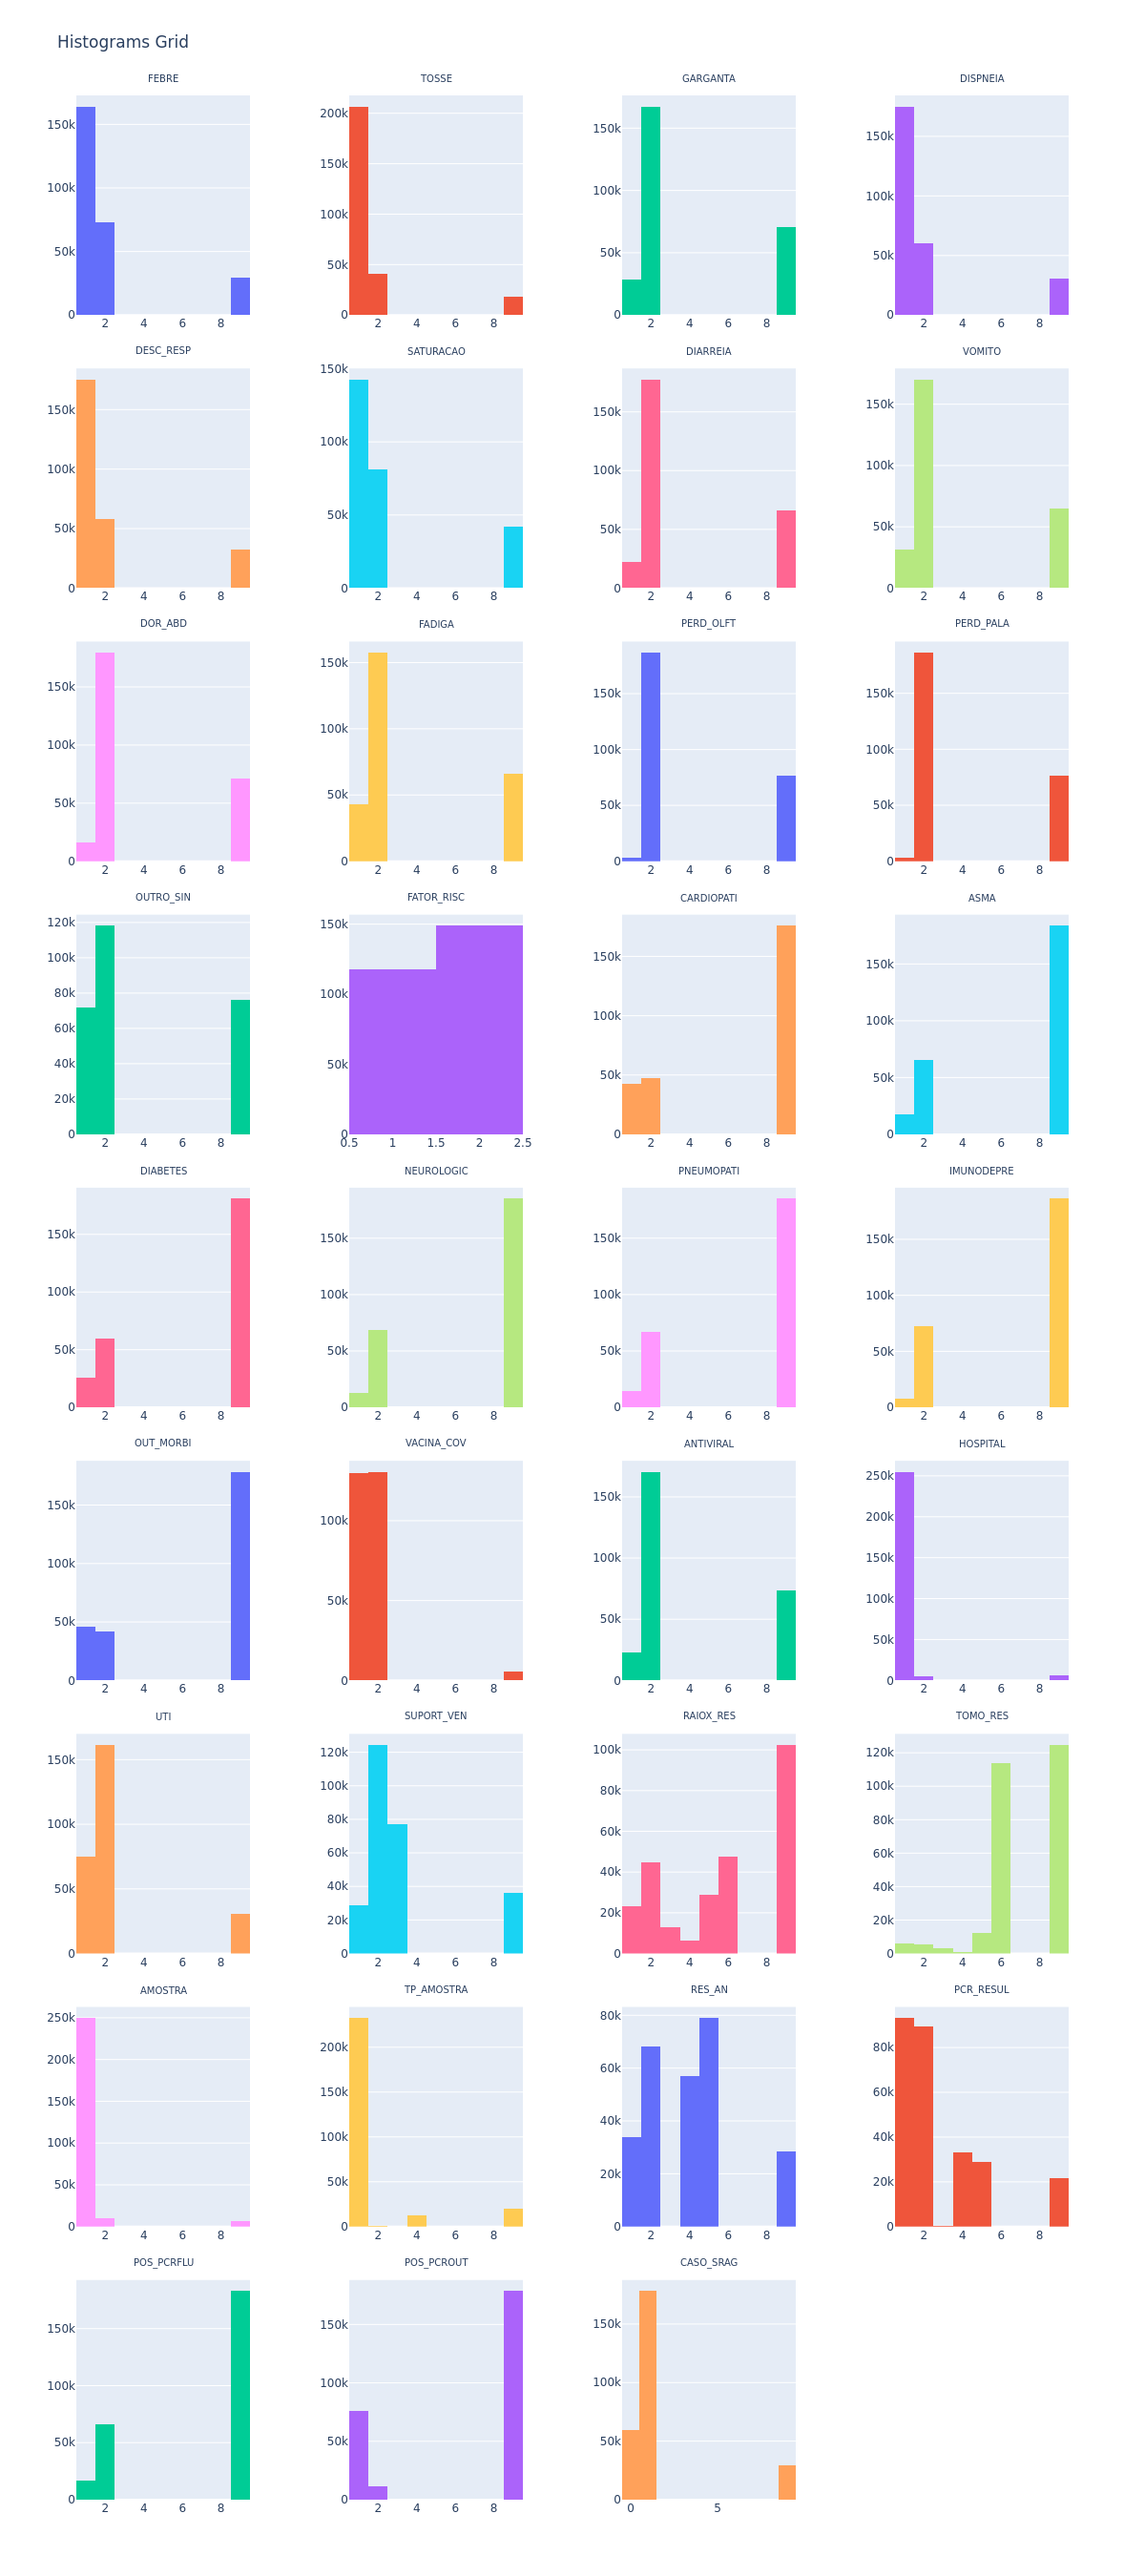

In [22]:
fig = plot_histograms_grid(df, max_plots_per_row=4, width=1200)
fig.show("png")

In [13]:
def corr_heatmap(df, width=1600, height=1600, fig_type=None):
    """   
    Generate a correlation heatmap for the DataFrame.
    """
    fig = px.imshow(df.corr(numeric_only=True), text_auto=True, aspect="equal", color_continuous_scale='RdBu_r', title='Heatmap of Correlation Coefficients')
    fig.update_layout(width=width, height=height)
    return fig.show(fig_type)

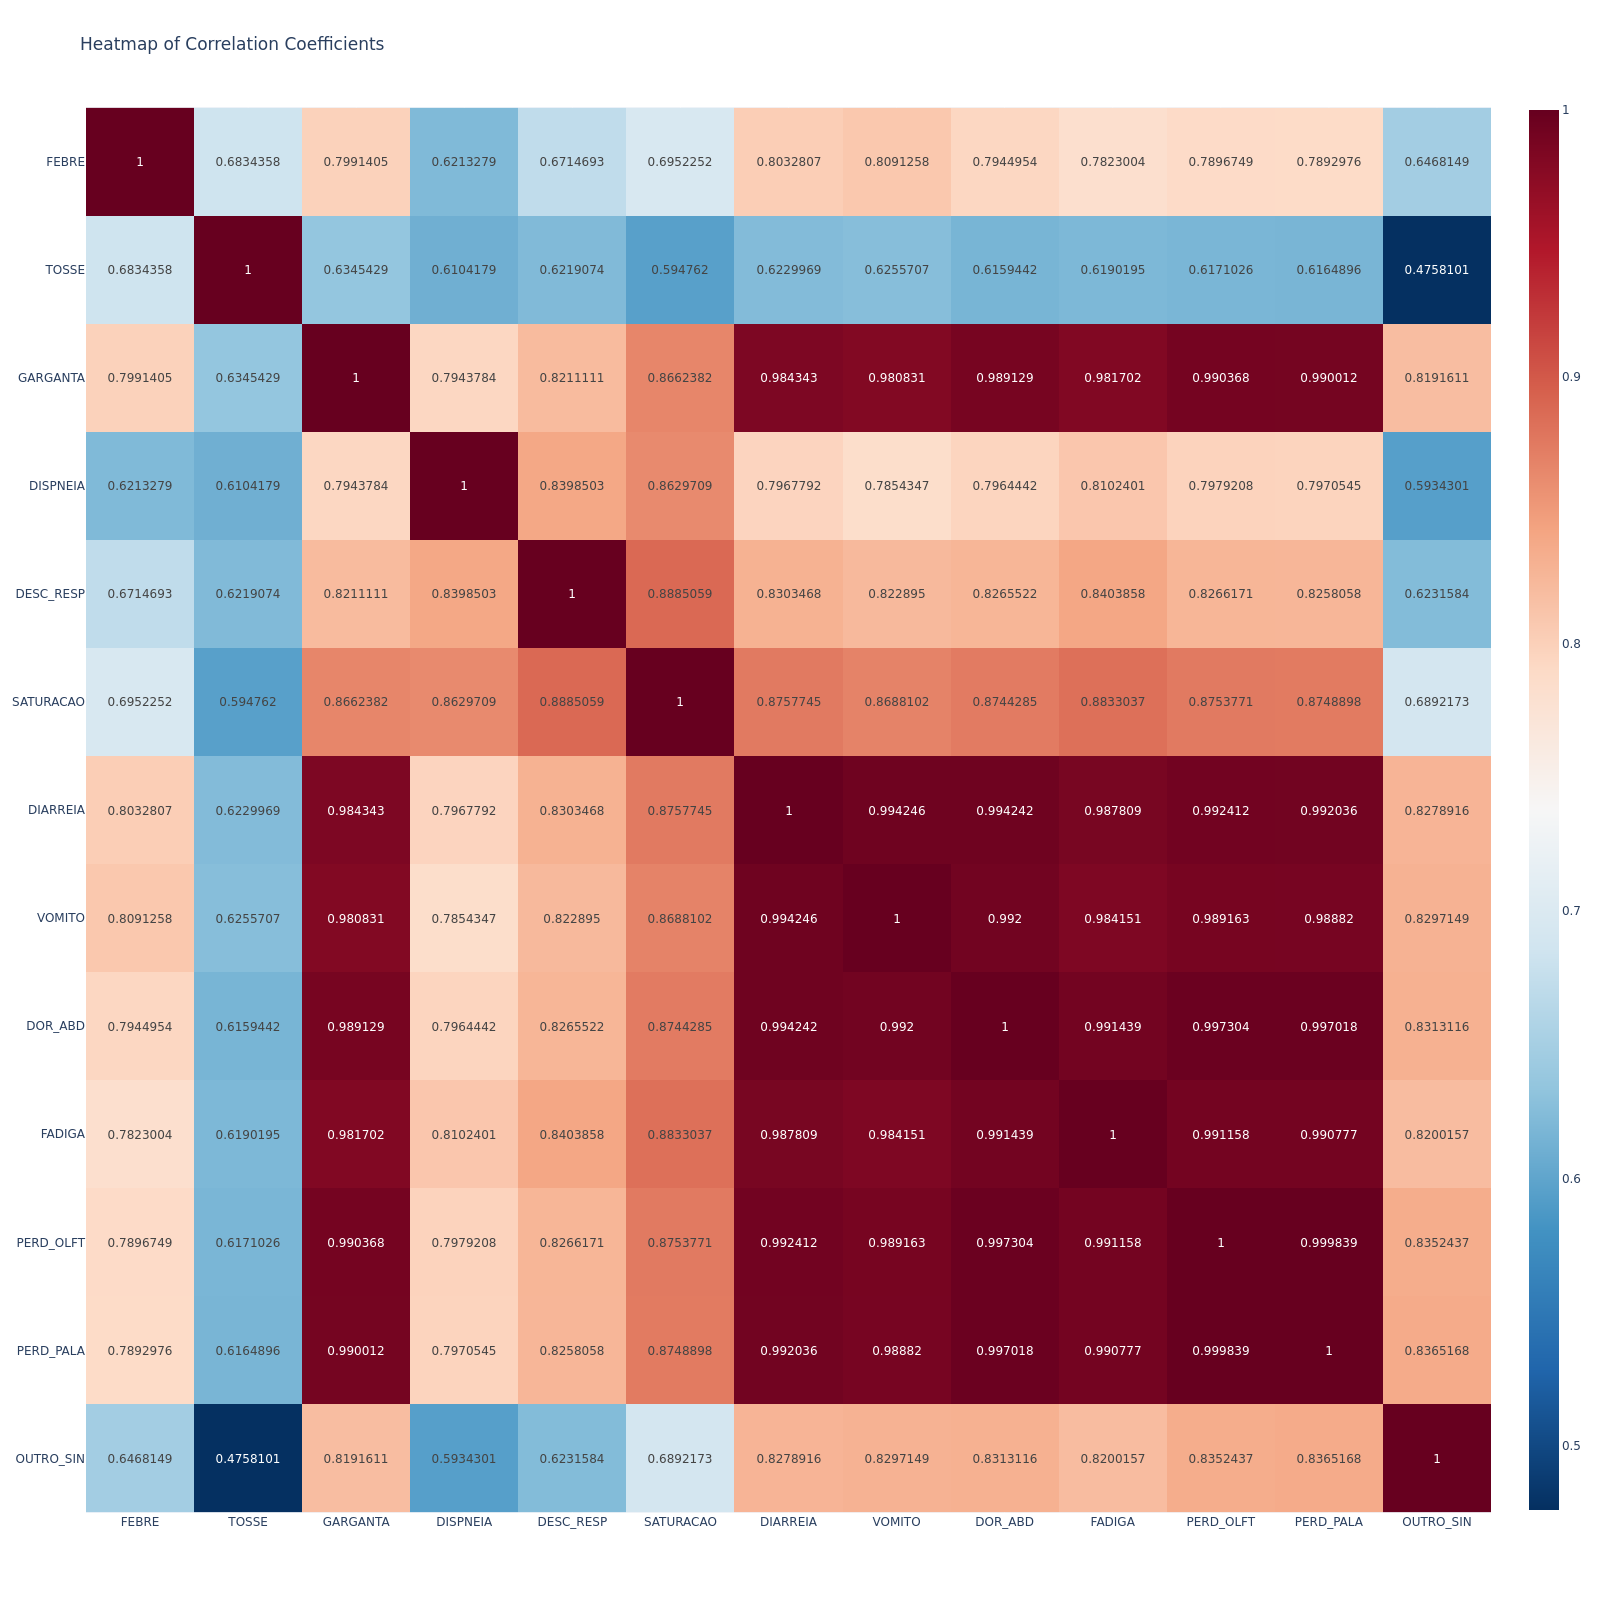

In [14]:
corr_heatmap(df.corr(numeric_only=True)[sinais_sintomas], fig_type="png")

## Partialling-Out / Residualization (FWL Theorem)

In [15]:
class PartiallingOutRegressor(BaseEstimator, RegressorMixin):
    """
    Implements partialling-out (regression residualization) technique for linear models.
    
    This technique removes the linear effect of a set of covariates before estimating
    the relationship between the target variable and features of interest.
    
    Parameters:
    -----------
    fit_intercept : bool, optional (default=True)
        Whether to calculate the intercept for the internal linear model.
        If False, no intercept will be used in calculations.
        
    Attributes:
    ----------
    model_ : sklearn.linear_model.LinearRegression
        The internal linear model used for residual calculation.
        
    feature_names_ : list or None
        Names of features (only available when X is a DataFrame).
        
    Examples:
    --------
    >>> import numpy as np
    >>> from sklearn.datasets import make_regression
    >>> X, y = make_regression(n_samples=100, n_features=3, noise=0.1)
    >>> por = PartiallingOutRegressor().fit(X[:, [0,1]], y)
    >>> residuals = por.transform(X[:, [0,1]], y)
    >>> # The residuals can now be used in subsequent analysis
    
    Notes:
    ------
    - Partialling-out is commonly used in econometrics ("net of" effects)
    - Mathematically equivalent to obtaining residuals from y ~ X regression
    - Particularly useful for removing confounder effects before analysis
    """
    
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.model_ = None 
        
    def fit(self, X, y):
        """
        Fit the residualization model.
        
        Parameters:
        -----------
        X : array-like, DataFrame or sparse matrix of shape (n_samples, n_features)
            Features used to calculate target residuals.
            
        y : array-like of shape (n_samples,)
            Target values.
            
        Returns:
        --------
        self : object
            Returns the instance itself.
        """
        if hasattr(X, 'columns'):
            self.feature_names_ = X.columns.tolist()
            
        self.model_ = LinearRegression(fit_intercept=self.fit_intercept)
        self.model_.fit(X, y)
        
        return self
    
    def transform(self, X, y):
        """
        Calculate target residuals after removing linear effects of features.
        
        Parameters:
        -----------
        X : array-like, DataFrame or sparse matrix of shape (n_samples, n_features)
            Features used for residual calculation.
            
        y : array-like of shape (n_samples,)
            Target values to be residualized.
            
        Returns:
        --------
        residuals : array of shape (n_samples,)
            Residuals from y ~ X regression (y values with linear effect of X removed).
            
        Raises:
        -------
        NotFittedError
            If the model hasn't been fitted prior to transformation.
        """
        if self.model_ is None:
            raise NotFittedError("This model must be fitted before transformation.")
                    
        residuals = y - self.model_.predict(X)
        return residuals
    
    def set_params(self, **params):
        """
        Set the parameters of this estimator.
        
        Parameters:
        -----------
        **params : dict
            Parameters to set (name=value).
            
        Returns:
        --------
        self : object
            The estimator instance.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [16]:
def create_residuals_mapping(symptoms_list):
    """
    Cria um dicionário de mapeamento de resíduos onde cada chave é um sintoma
    e o valor é a lista de todos os outros sintomas que ainda não foram incluídos.
    
    Args:
        symptoms_list: Lista de sintomas (ex: sinais_sintomas)
    
    Returns:
        Dicionário no formato {sintoma: [outros_sintomas_restantes]}
    """
    residuals_mapping = {}
    accumulated_exclusions = []
    
    for symptom in symptoms_list:
        predictors = [x for x in symptoms_list if x not in accumulated_exclusions + [symptom]]
        if len(predictors) == 0:
            break
        residuals_mapping[symptom] = predictors
        accumulated_exclusions.append(symptom)
    
    return residuals_mapping

def training_multiple_residual_models(data, residuals):
    residual_models = {}
    for features, target in residuals:
        X = np.asarray(data)
        y = np.asarray(data)
        residual_model = PartiallingOutRegressor()
        residual_models[target] = residual_model.fit(X[:, features], y[:, target])
    return residual_models

In [17]:
def preprocessing(df: pd.DataFrame, residuals, models):
    df = df.copy()
    for features, target in residuals:
        X = np.asarray(df.iloc[:, features])
        y = np.asarray(df.iloc[:, target])
        df.iloc[:, target] = models[target].transform(X, y)
    return df

In [18]:
get_index = df.columns.get_indexer

In [19]:
residuals_mapping = create_residuals_mapping(sinais_sintomas)
residuals = [
    (get_index(predictors), get_index([target])[0])
    for target, predictors in residuals_mapping.items()
]
residual_models = training_multiple_residual_models(df, residuals)
df = preprocessing(df, residuals, residual_models)

# Sinais e Sintomas

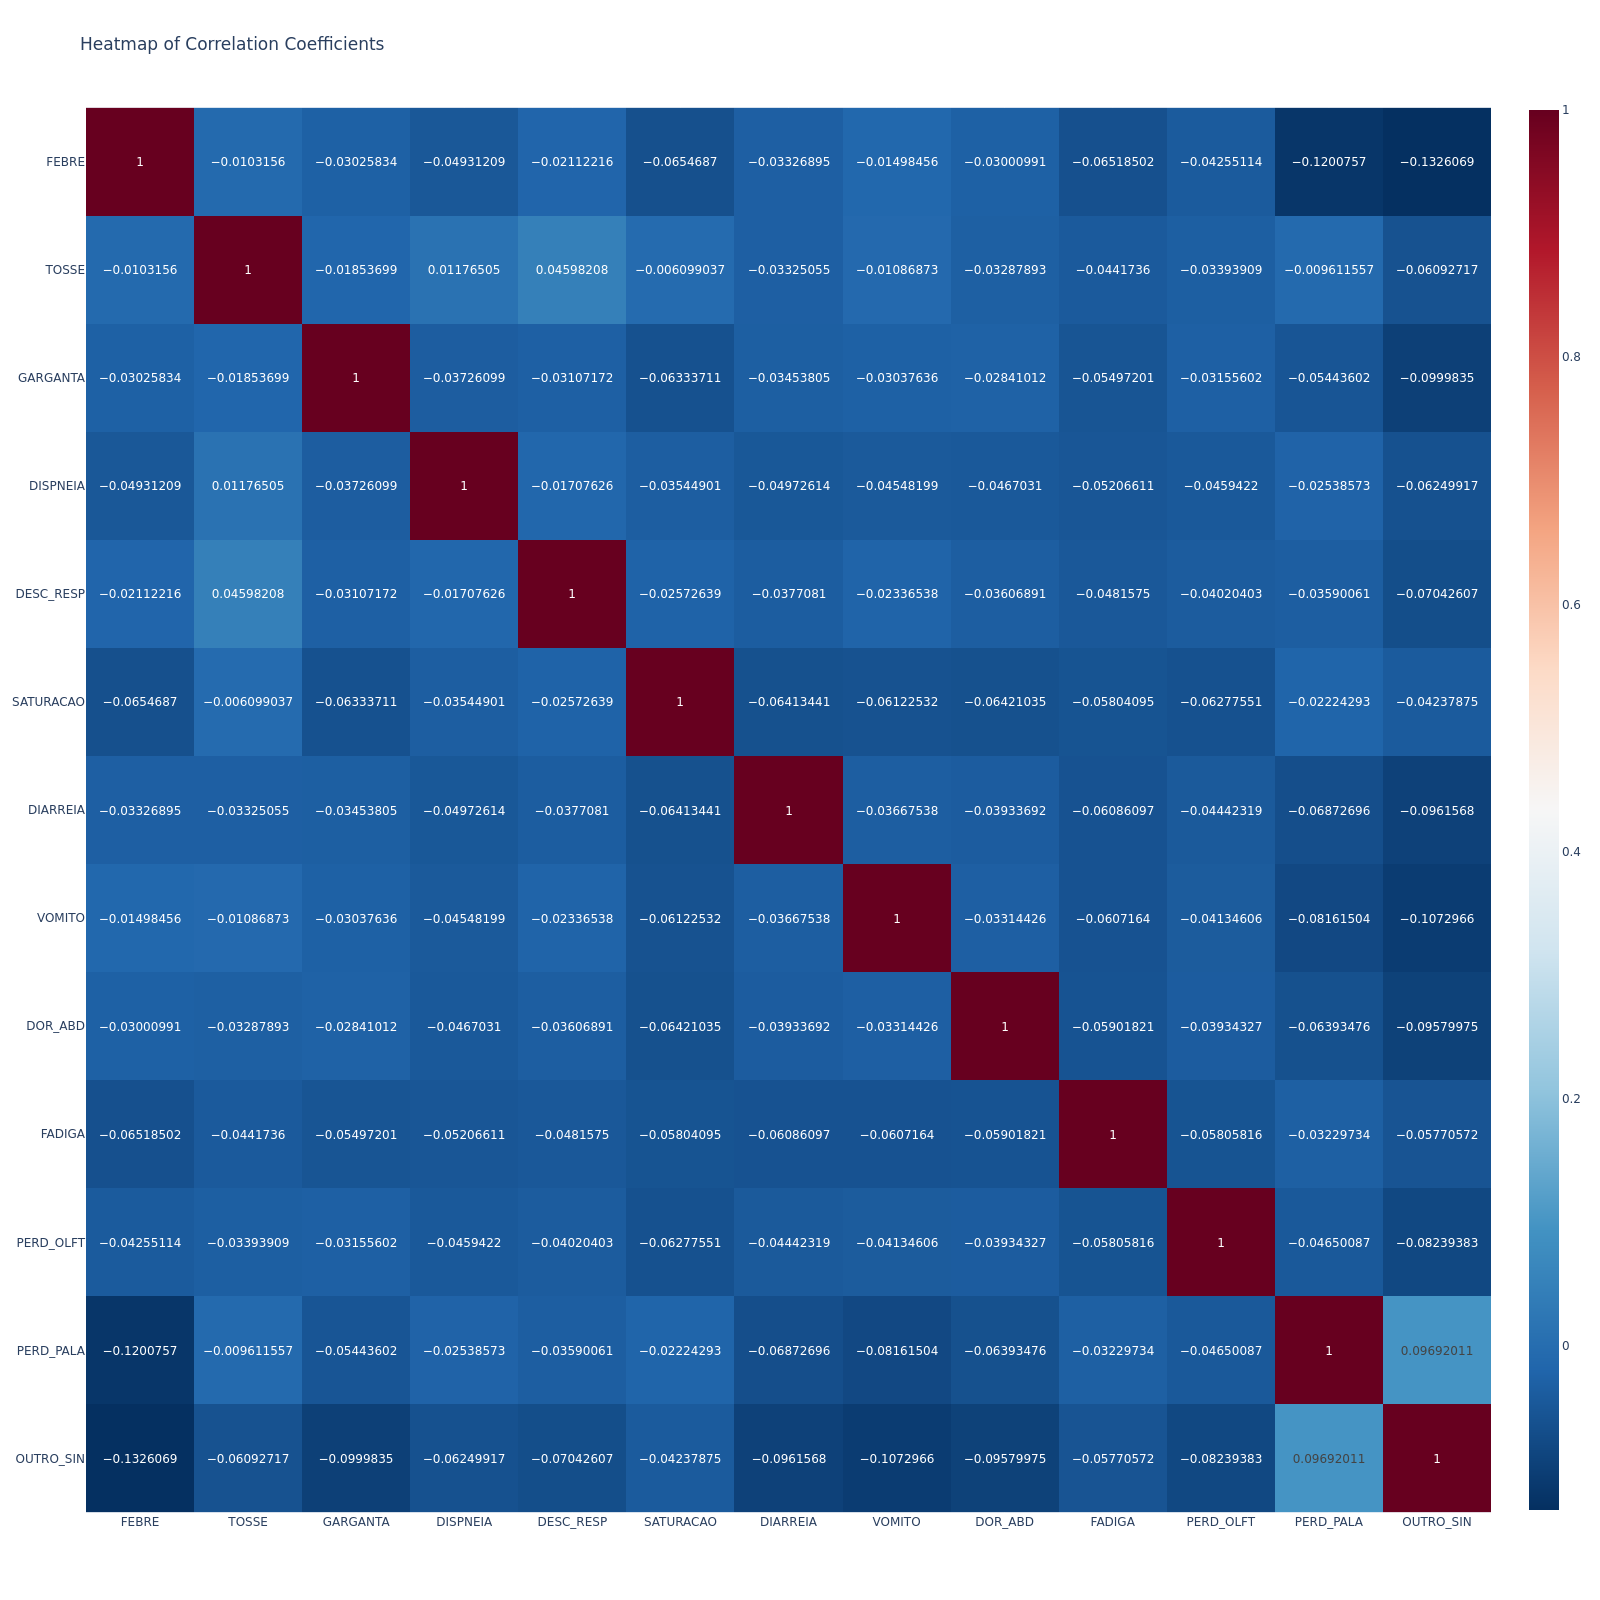

In [20]:
corr_heatmap(df.corr(numeric_only=True)[sinais_sintomas], fig_type="png")

# Fatores de Risco

In [21]:
residuals_mapping = create_residuals_mapping(fatores_risco)
residuals = [
    (get_index(predictors), get_index([target])[0])
    for target, predictors in residuals_mapping.items()
]
residual_models = training_multiple_residual_models(df, residuals)
df = preprocessing(df, residuals, residual_models)

/tmp/ipykernel_68731/262250446.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.88348038 -0.35438665  0.07226395 ...  0.04846049  0.11651962
  0.11651962]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



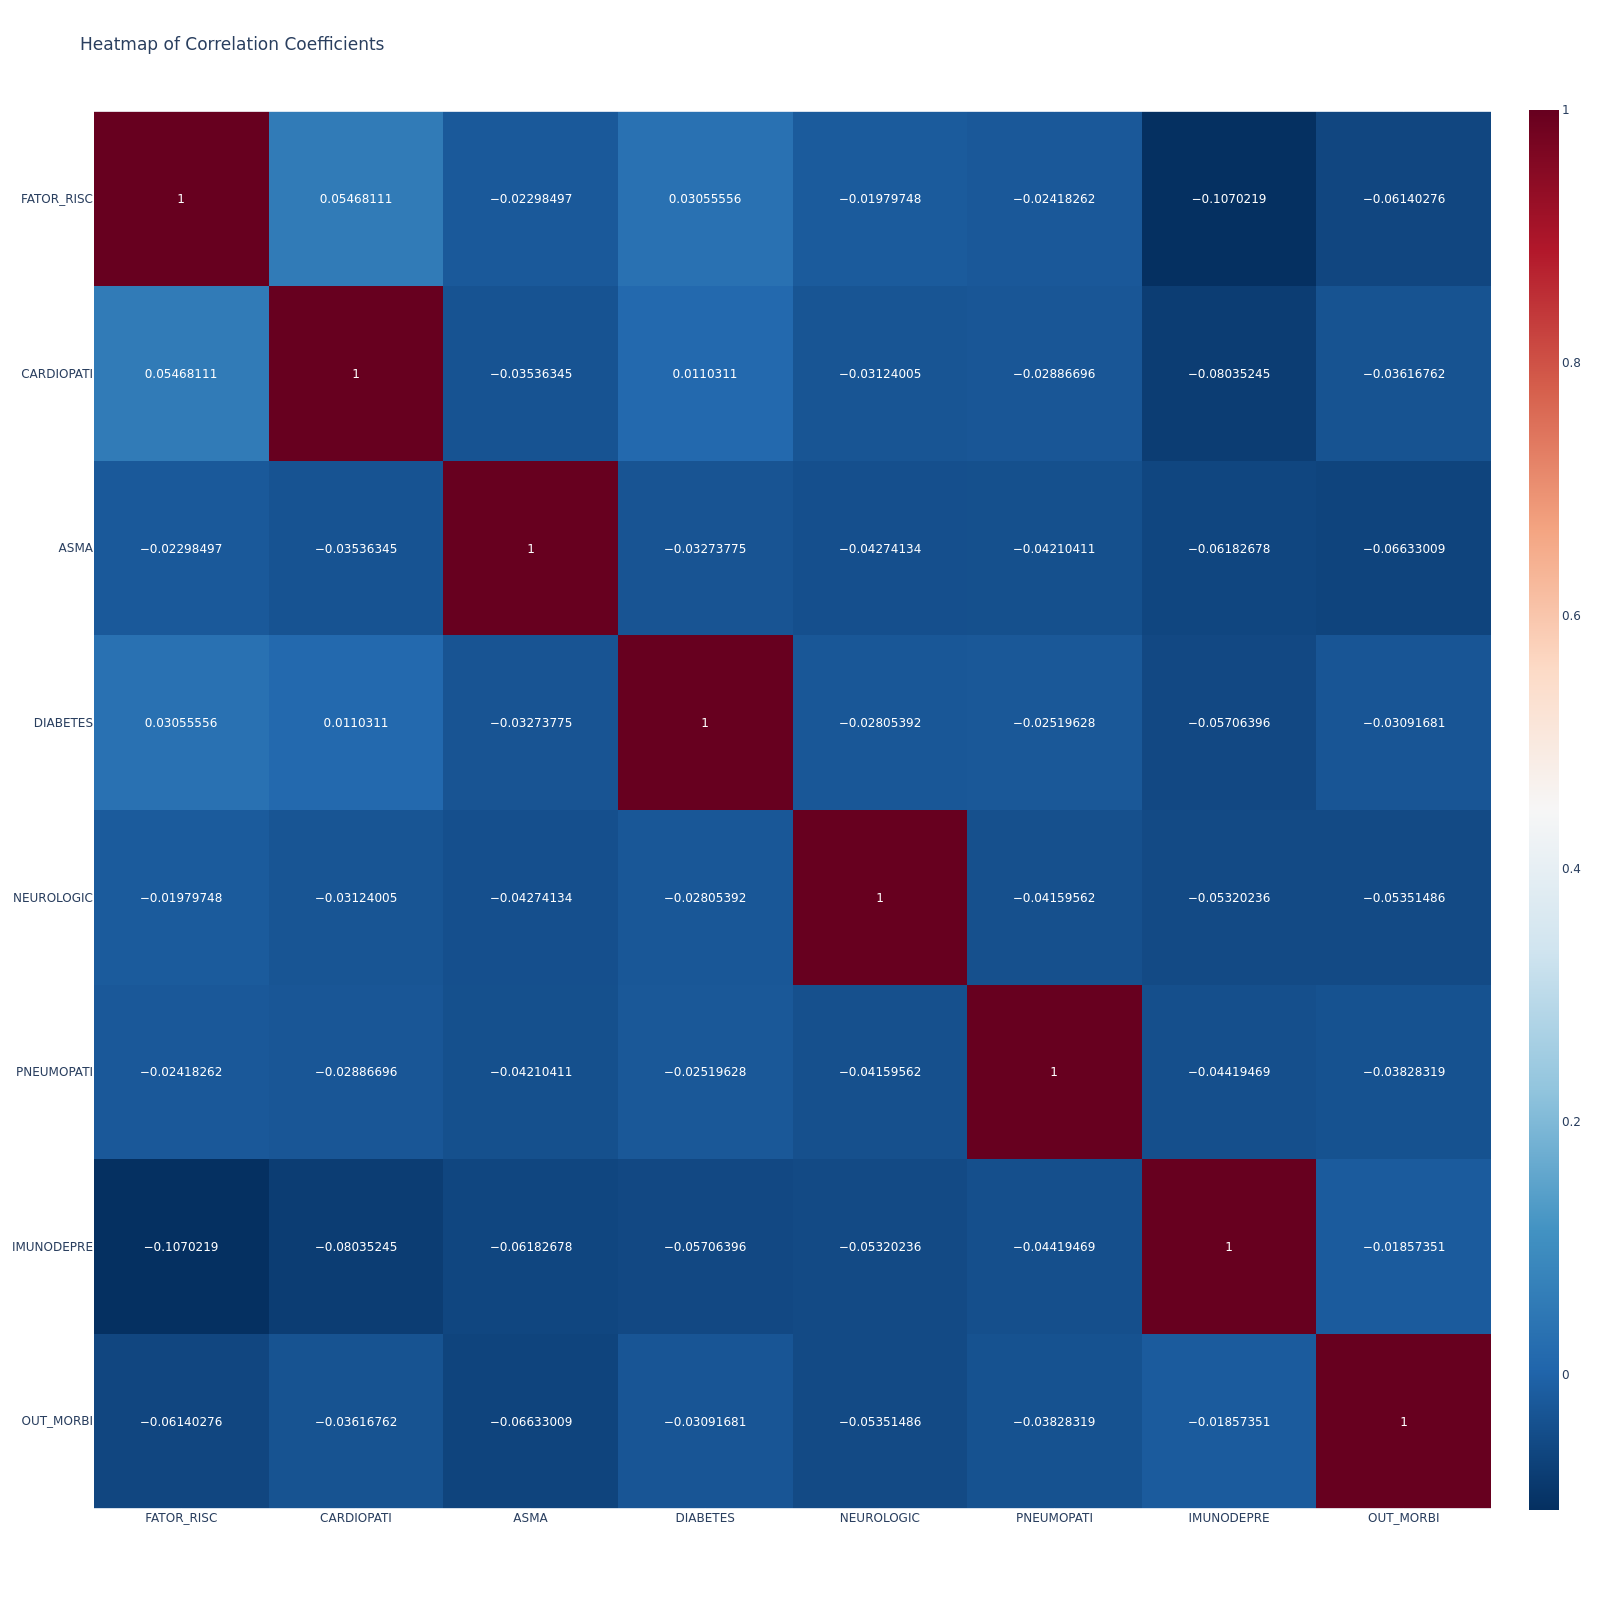

In [22]:
corr_heatmap(df.corr(numeric_only=True)[fatores_risco], fig_type="png")

# Internação

In [23]:
residuals_mapping = create_residuals_mapping(internacao)
residuals = [
    (get_index(predictors), get_index([target])[0])
    for target, predictors in residuals_mapping.items()
]
residual_models = training_multiple_residual_models(df, residuals)
df = preprocessing(df, residuals, residual_models)

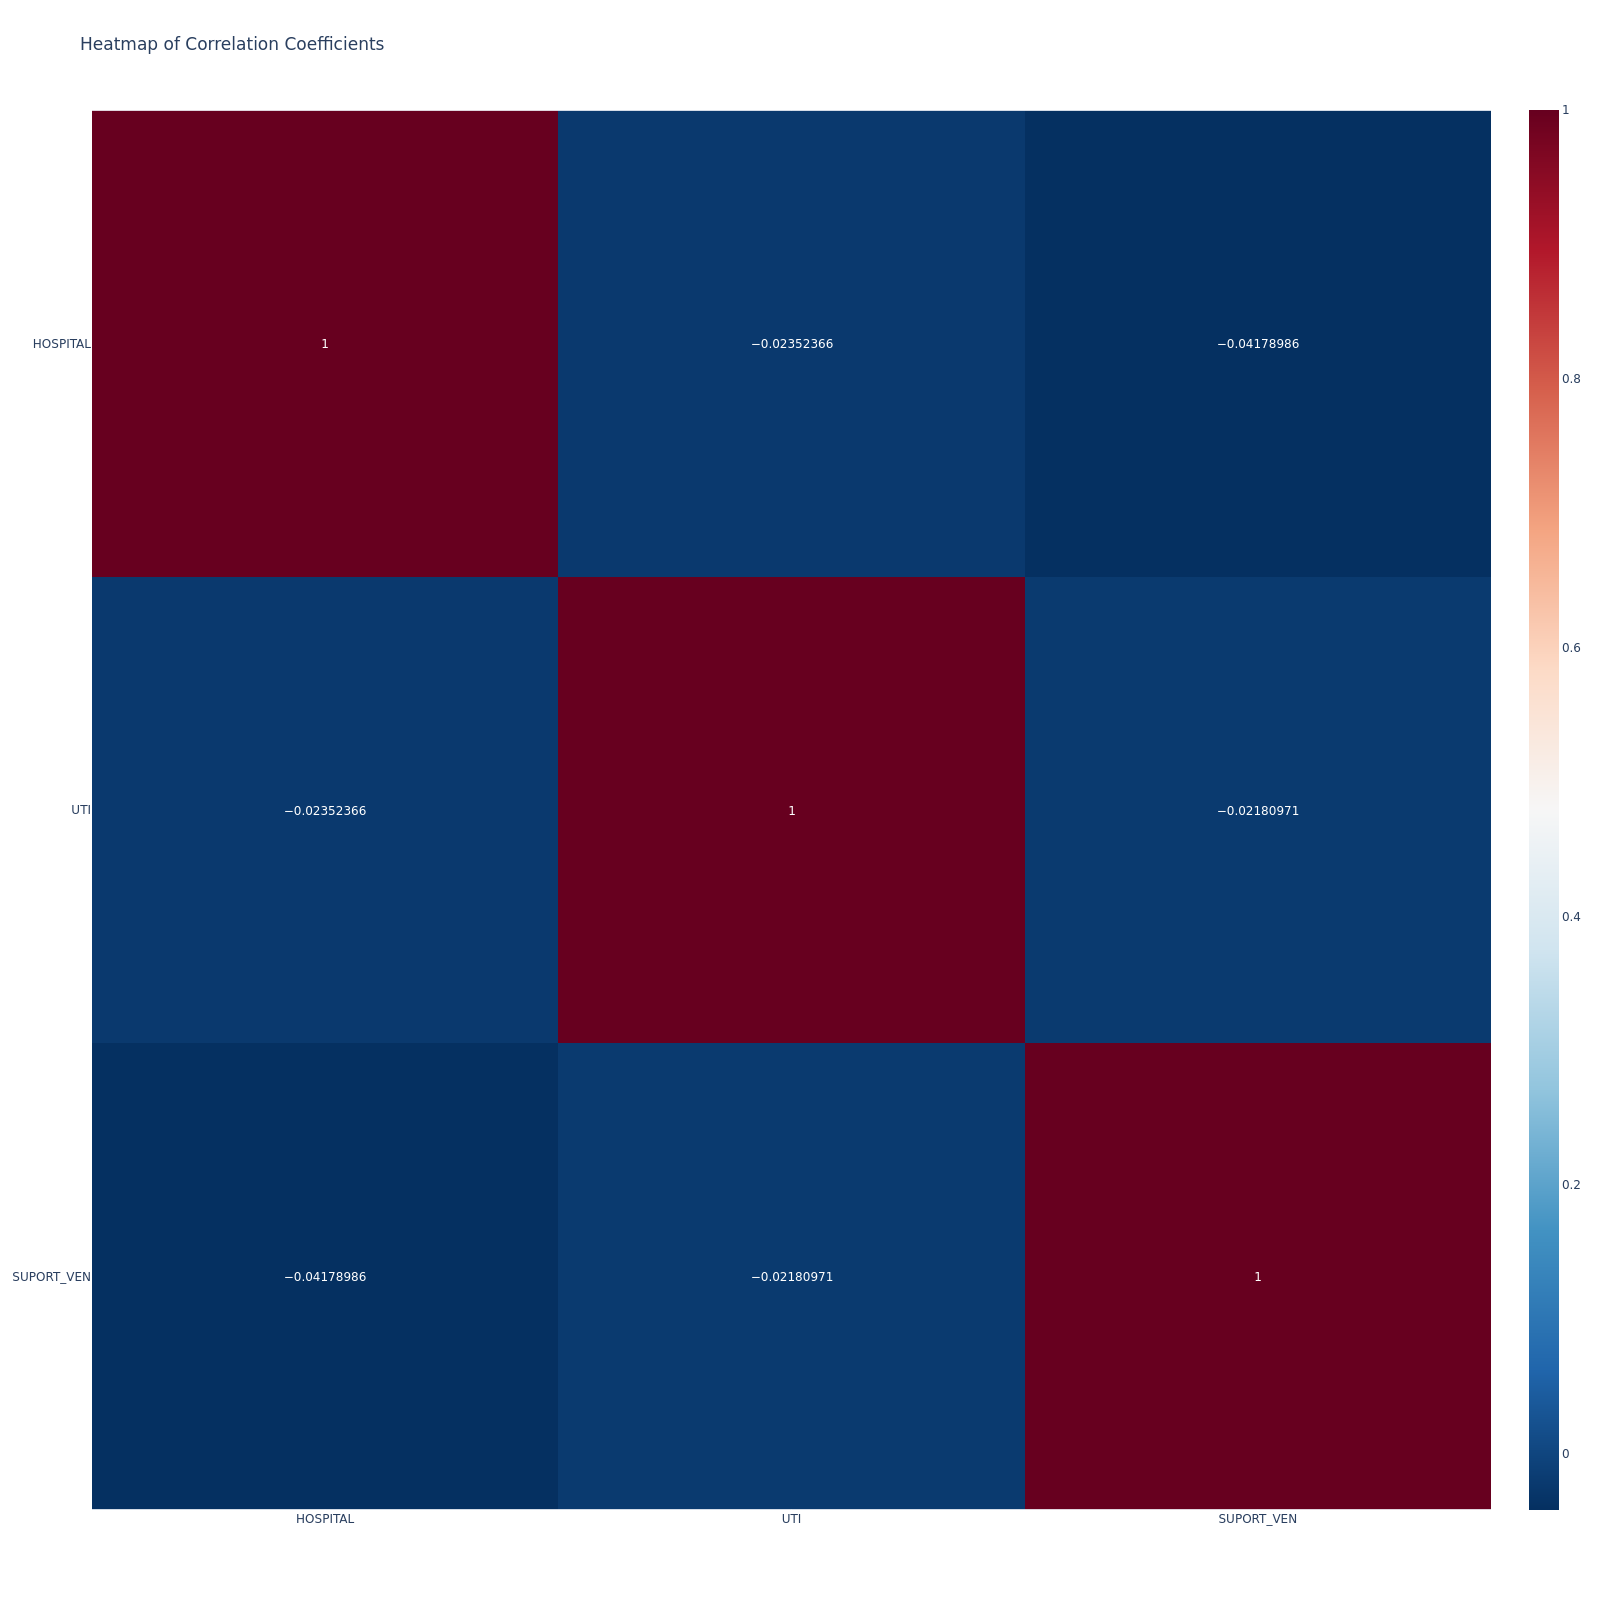

In [24]:
corr_heatmap(df.corr(numeric_only=True)[internacao], fig_type="png")

# Exames

In [25]:
residuals_mapping = {
    'RAIOX_RES': ["TOMO_RES"],
    'RAIOX_RES': ["TOMO_RES"],
    'AMOSTRA': ["TP_AMOSTRA"],
}

In [26]:
residuals = [
    (get_index(predictors), get_index([target])[0])
    for target, predictors in residuals_mapping.items()
]
residual_models = training_multiple_residual_models(df, residuals)
df = preprocessing(df, residuals, residual_models)

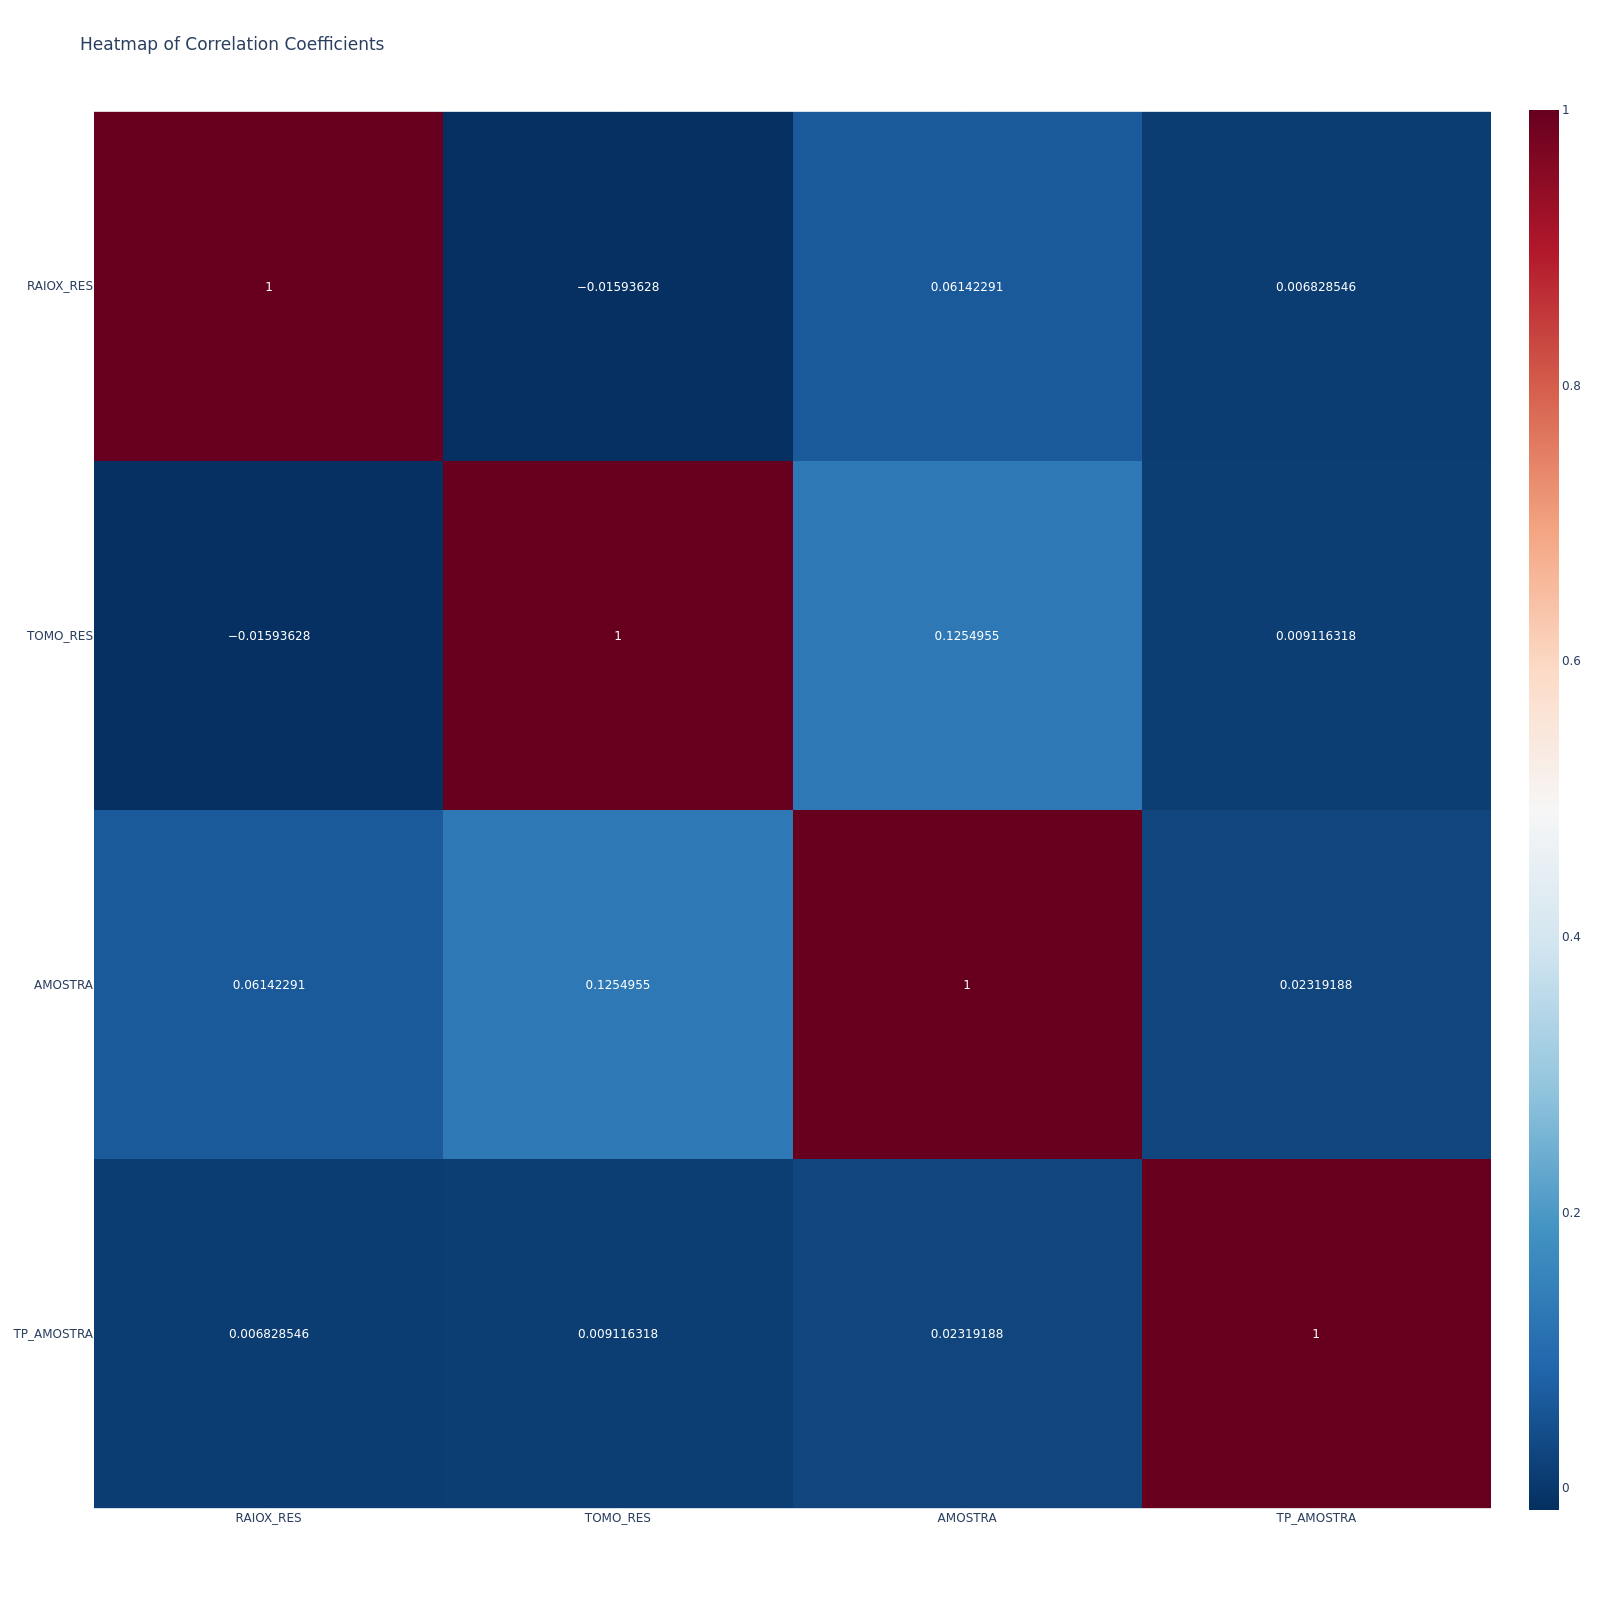

In [27]:
corr_heatmap(df.corr(numeric_only=True)[exames], fig_type="png")

# RT PCR

In [28]:
residuals_mapping = create_residuals_mapping(rt_pcr)
residuals = [
    (get_index(predictors), get_index([target])[0])
    for target, predictors in residuals_mapping.items()
]
residual_models = training_multiple_residual_models(df, residuals)
df = preprocessing(df, residuals, residual_models)

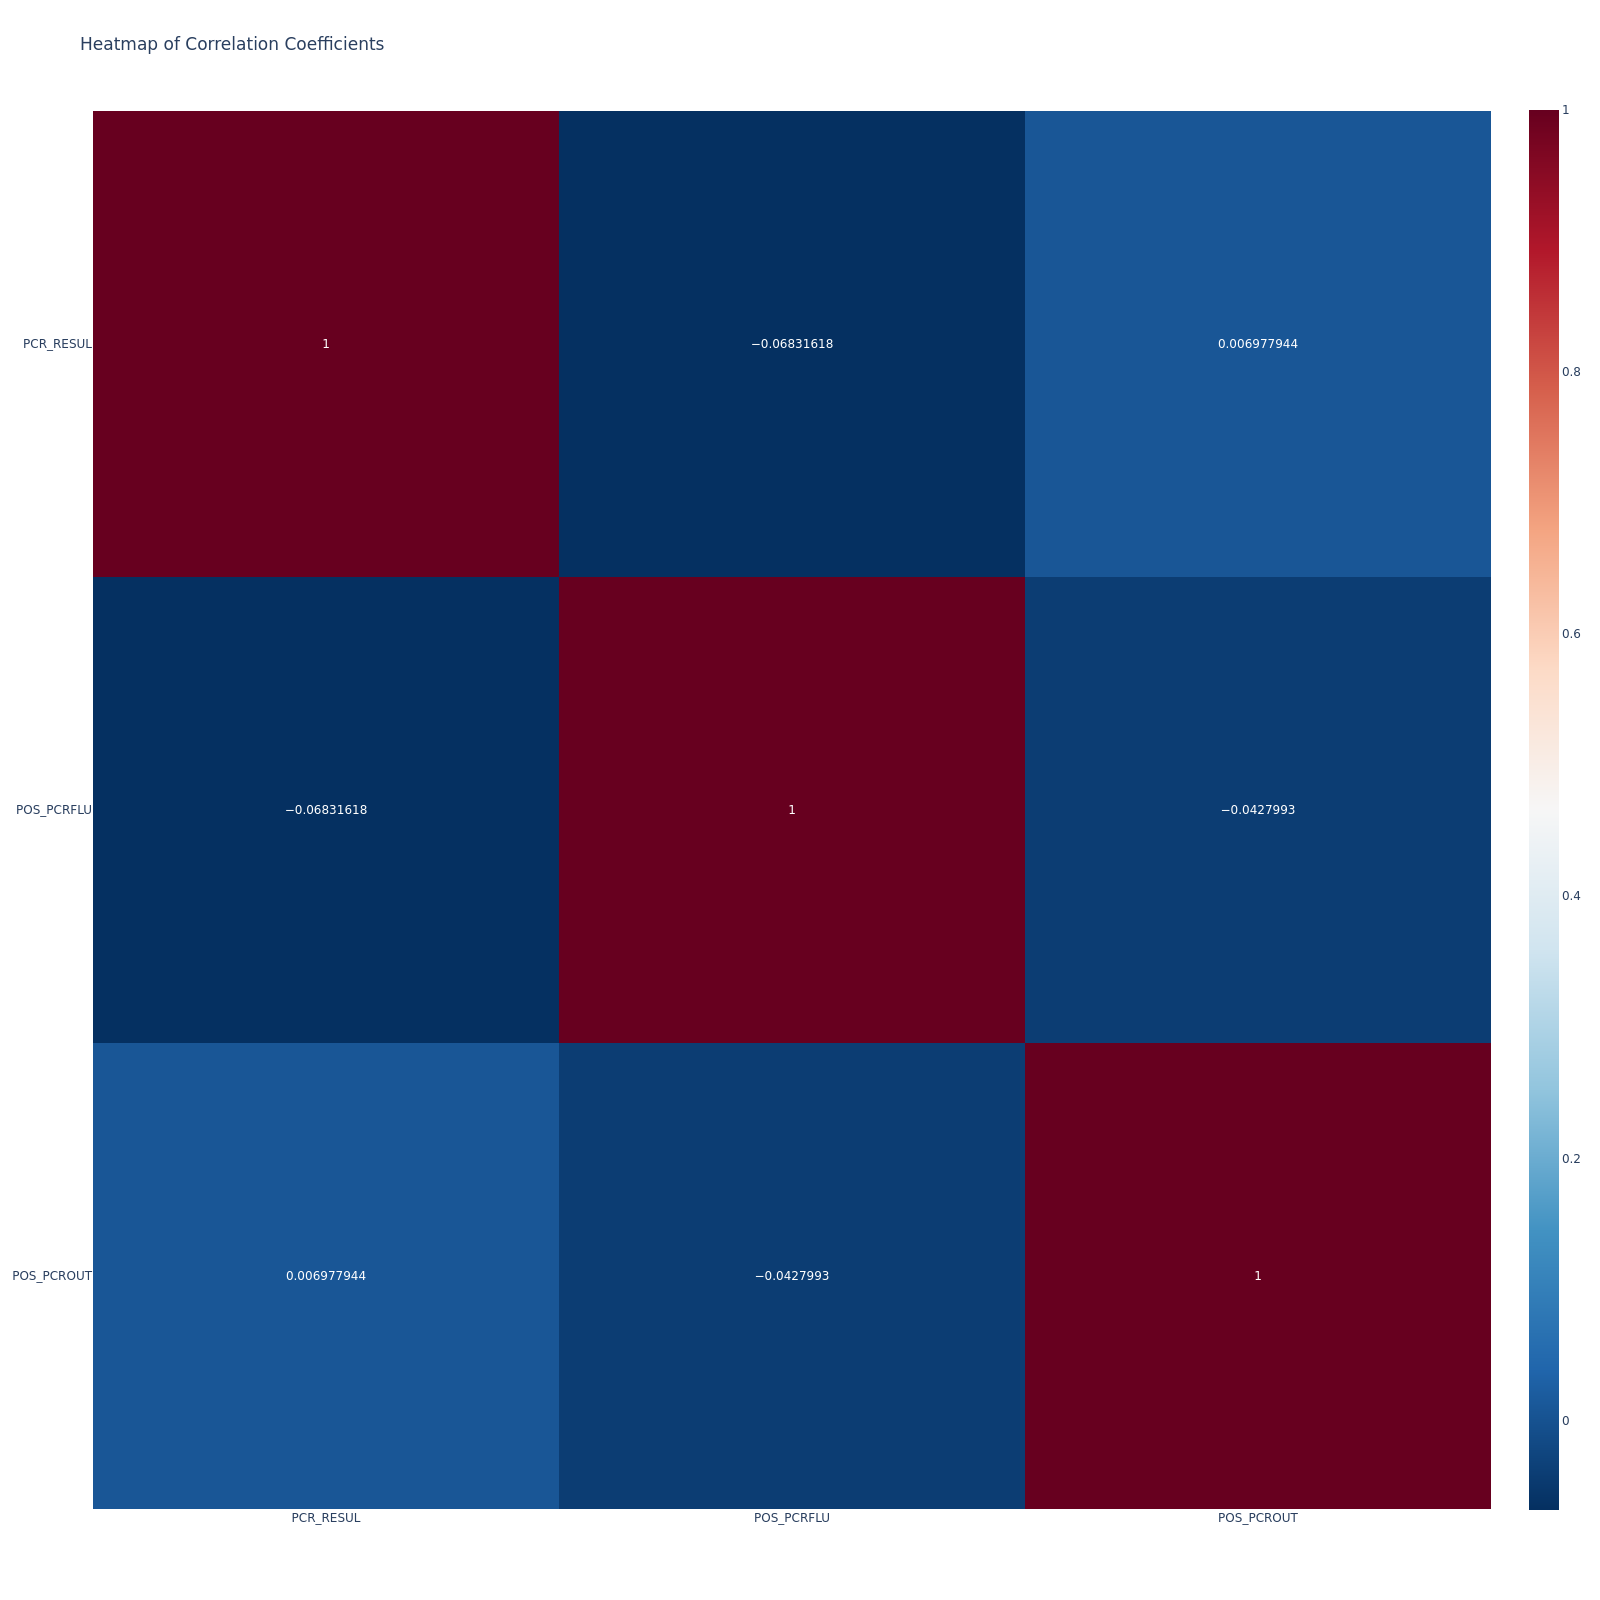

In [29]:
corr_heatmap(df.corr(numeric_only=True)[rt_pcr], fig_type="png")

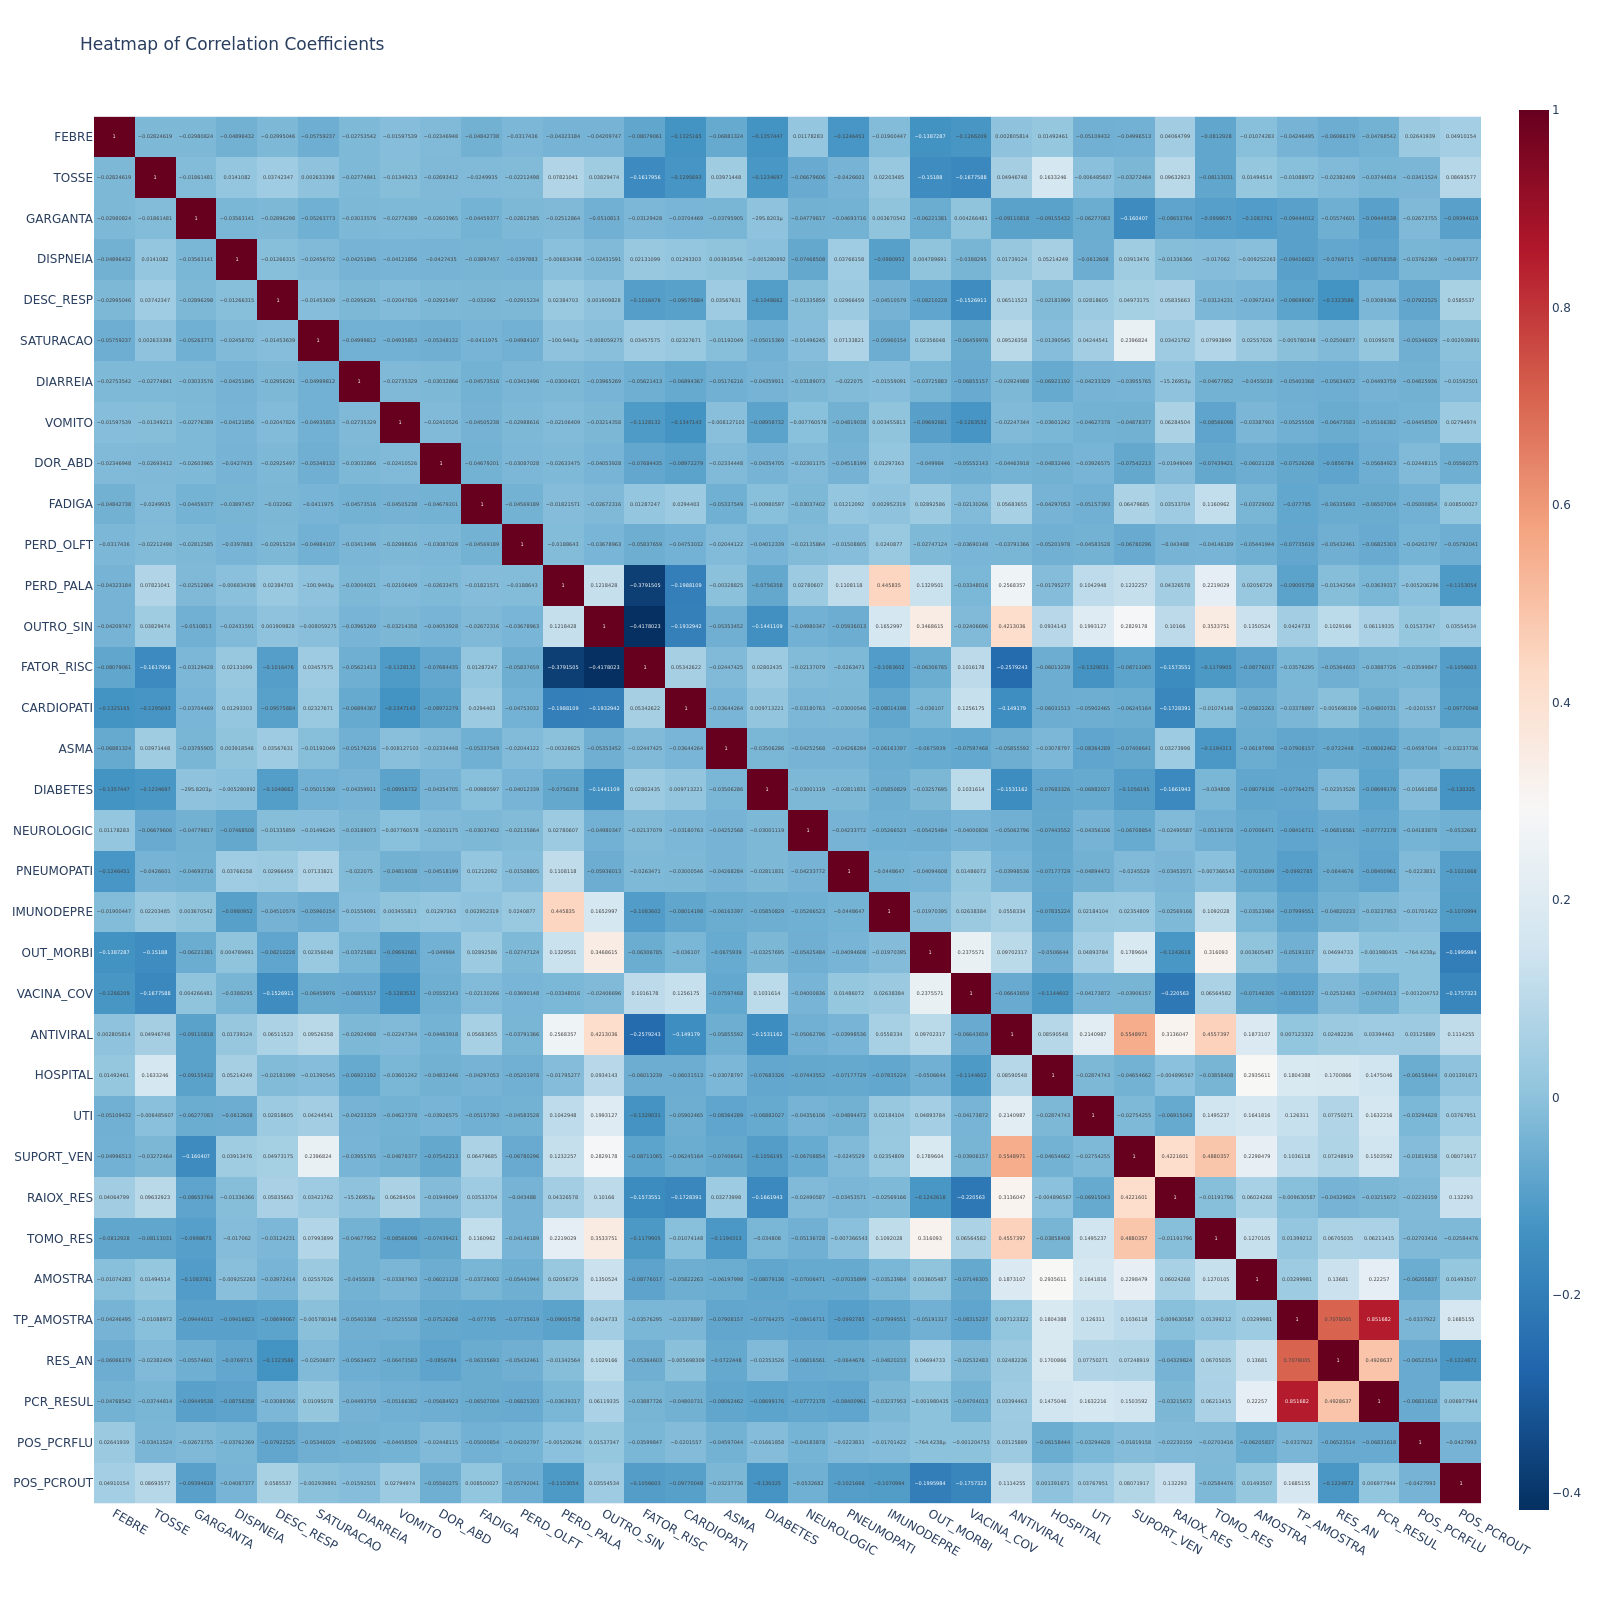

In [30]:
corr_heatmap(df.corr(numeric_only=True)[columns], fig_type="png")

In [31]:
def generate_vif_dataframe(df, features):

    def _vif_rank(data):
        if 1 < data < 5:
            return "Low"
        elif 5 <= data < 15:
            return "Moderate"
        elif 15 <= data < 20:
            return "High"
        elif 20 <= data < 30:
            return "Very High"
        return "Extreme"
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) for i in range(df[features].shape[1])]
    vif_data["Tolerance"] = 1 / vif_data["VIF"]
    vif_data["VIF Rank"] = vif_data["VIF"].apply(_vif_rank)
    return vif_data

In [32]:
def vif_with_target(df, features, target='povertyPercent'):
    vif_results = []
    for feat in features:
        if feat == target:
            continue
        X_pair = df[[target, feat]].dropna()
        vif = [variance_inflation_factor(X_pair.values, i) for i in range(X_pair.shape[1])]
        vif_results.append({'feature': feat, f'VIF_{target}': vif[1]})
    return pd.DataFrame(vif_results).sort_values(by=f'VIF_{target}', ascending=False)

In [33]:
generate_vif_dataframe(df, columns)

,feature,VIF,Tolerance,VIF Rank
0,FEBRE,1.018185,0.982140,Low
1,TOSSE,1.024483,0.976102,Low
2,GARGANTA,1.004688,0.995334,Low
3,DISPNEIA,1.013024,0.987143,Low
4,DESC_RESP,1.021251,0.979191,Low
5,SATURACAO,1.040995,0.960619,Low
6,DIARREIA,1.003772,0.996242,Low
7,VOMITO,1.012240,0.987908,Low
8,DOR_ABD,1.005602,0.994429,Low
9,FADIGA,1.012955,0.987211,Low


In [34]:
def filtering_features_based_on_vif(X: np.ndarray, threshold=15.0, verbose=False):
    """
    Filter features based on Variance Inflation Factor (VIF).
    Features with VIF above the threshold are removed iteratively."""

    if not isinstance(threshold, (int, float)):
        raise ValueError("Threshold must be a numeric value.")
    if not isinstance(verbose, bool):
        raise ValueError("Verbose must be a boolean value.")
    if X.size == 0:
        raise ValueError("Input X cannot be empty.")
    if X.shape[0] < 2:
        raise ValueError("Input X must have at least two samples.")
    if X.shape[1] < 2:
        raise ValueError("Input X must have at least two features.")

    X = np.asanyarray(X)
    features = np.ones(X.shape[1], dtype=bool)
    for _ in range(features.shape[0]):
        vif = np.zeros(features.shape[0])
        mask = np.where(features)
        vif[mask] = [variance_inflation_factor(X[:, features], i) for i in range(X[:, features].shape[1])]
        max_vif = max(vif)
        idx_max_vif = np.argmax(vif)
        if max_vif >= threshold:
            if verbose:
                print(f"Index of feature with max VIF: {idx_max_vif}")
                print(f"Removing feature with VIF: {max_vif}")
            features[idx_max_vif] = False
            continue
        else:
            break
    return features

In [35]:
mask_features = filtering_features_based_on_vif(df[columns].astype(float), threshold=15)
filtered_features = np.asarray(columns)[mask_features]

In [36]:
filtered_features

array(['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO',
       'DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA', 'PERD_OLFT',
       'PERD_PALA', 'OUTRO_SIN', 'FATOR_RISC', 'CARDIOPATI', 'ASMA',
       'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'OUT_MORBI',
       'VACINA_COV', 'ANTIVIRAL', 'HOSPITAL', 'UTI', 'SUPORT_VEN',
       'RAIOX_RES', 'TOMO_RES', 'AMOSTRA', 'TP_AMOSTRA', 'RES_AN',
       'PCR_RESUL', 'POS_PCRFLU', 'POS_PCROUT'], dtype='<U10')

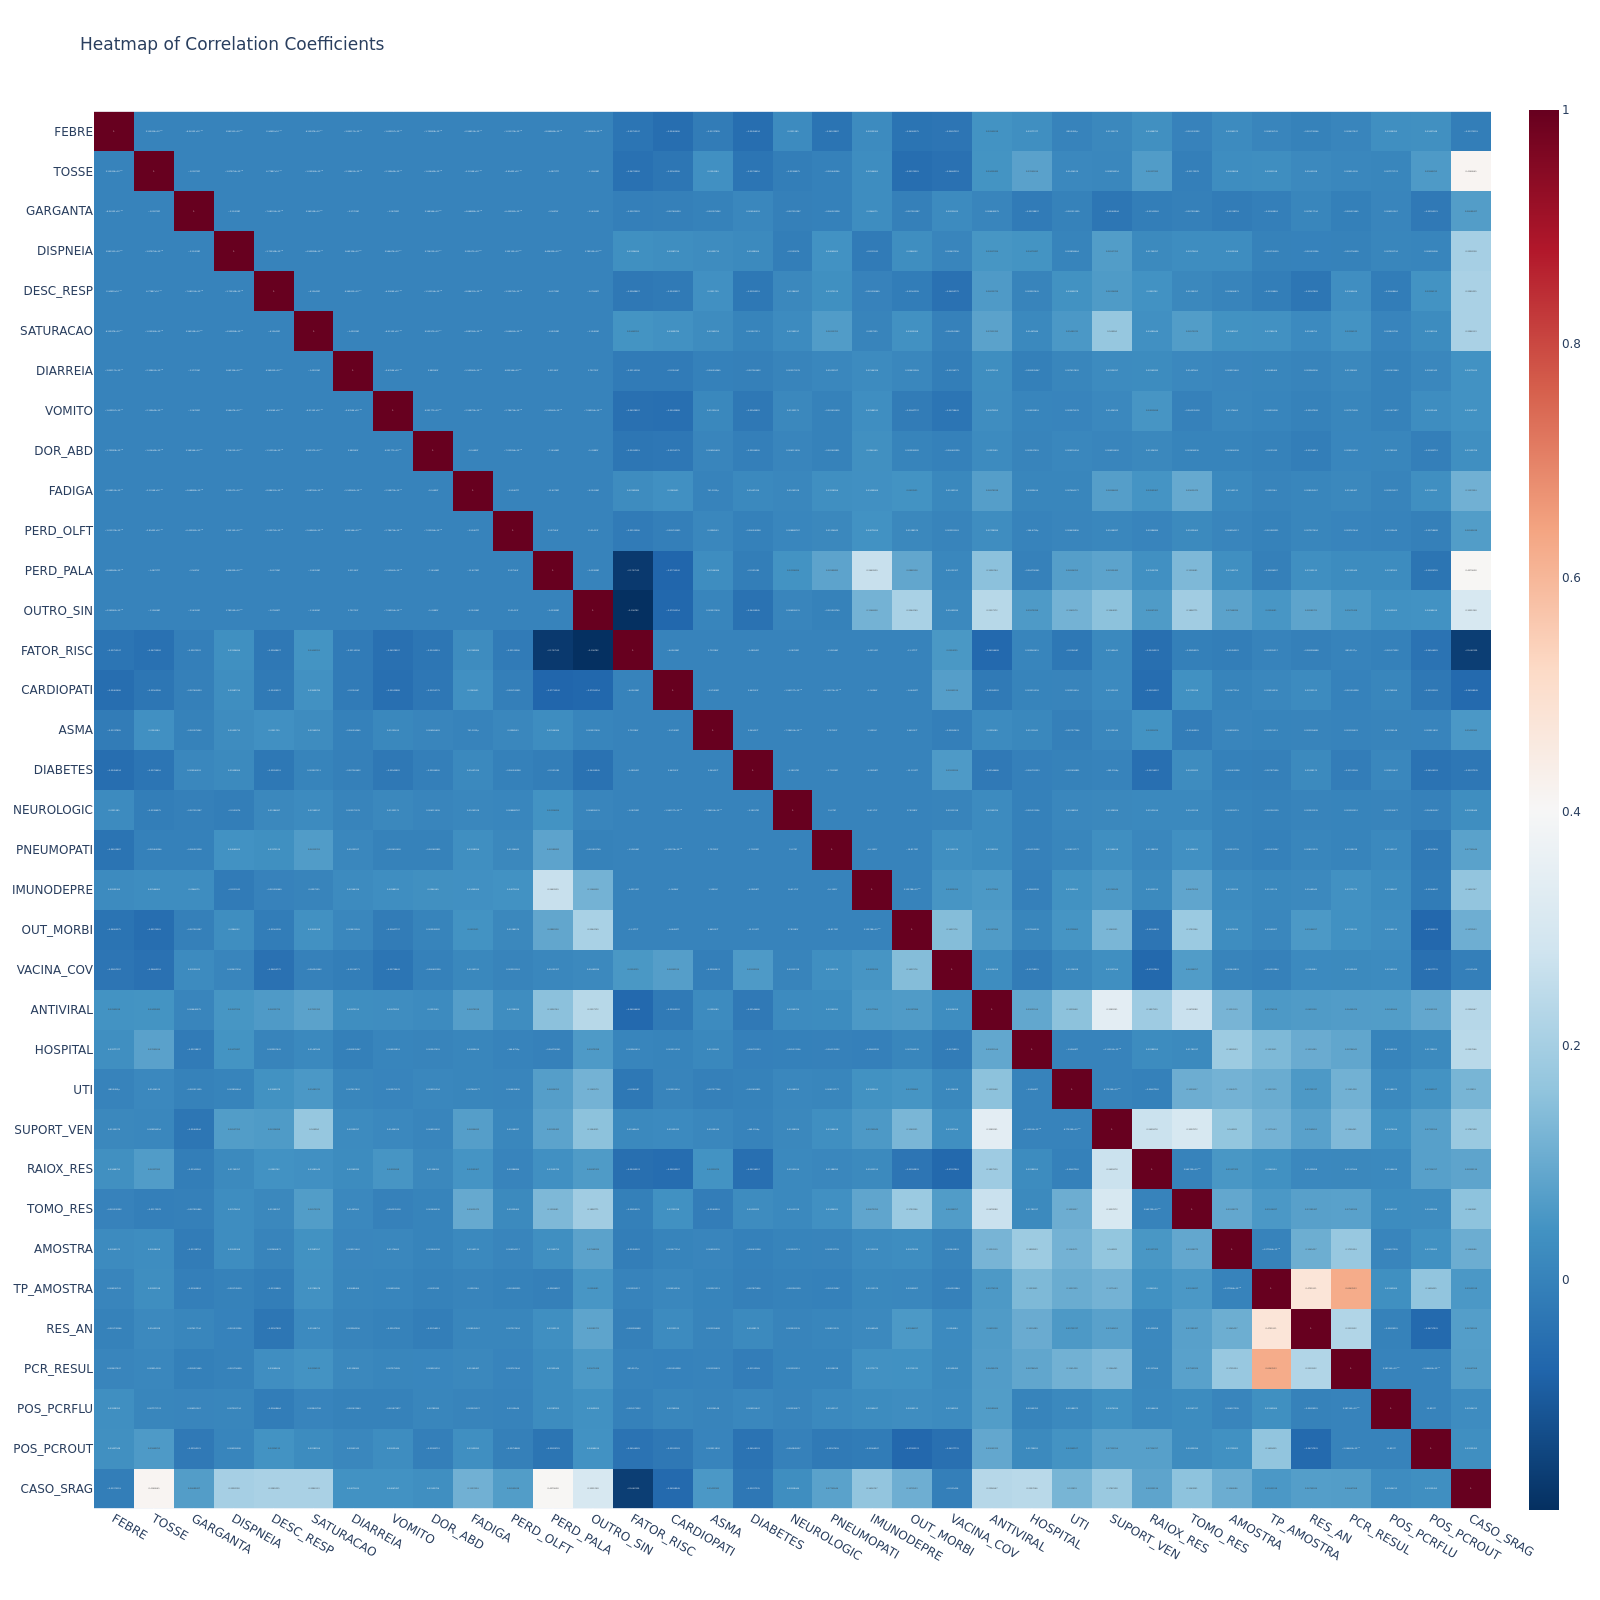

In [37]:
corr_heatmap(df[filtered_features.tolist() + target], width=1600, height=1600, fig_type="png")

In [38]:
def plot_barplot_corr_with_target(df, target):
    corr = df.corr(numeric_only=True)[target].drop(target).sort_values()
    plt.figure(figsize=(8, 12))
    sns.barplot(x=corr.values, y=corr.index, palette='RdBu_r')
    plt.title(f'Correlation Coefficients from {target}')
    plt.xlabel('Correlation Coefficients')
    plt.ylabel('Feature')
    plt.show()

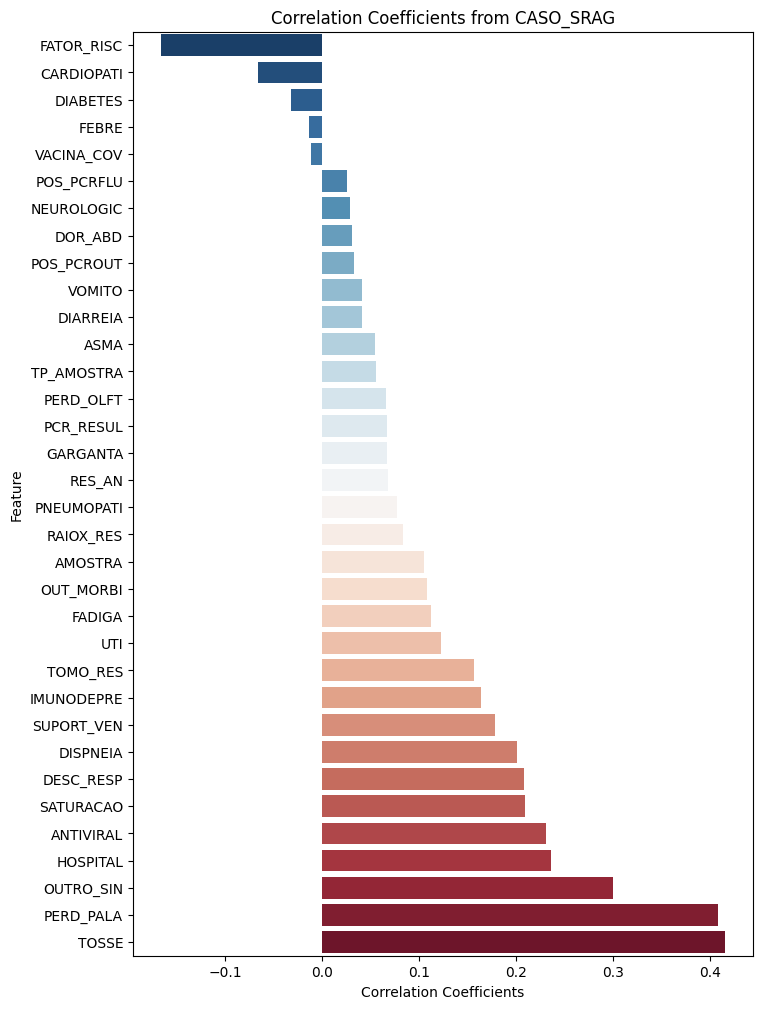

In [39]:
plot_barplot_corr_with_target(df[filtered_features.tolist() + target], "CASO_SRAG")

In [ ]:
filtered_features

In [41]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)